<a href="https://colab.research.google.com/github/VaishKBhat/research-project/blob/main/keywordsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import csv
import hashlib
import os
from collections import defaultdict
import base64
import time
import json

class SecureKeywordSearchRanked:
    def __init__(self):
        self.documents = []
        self.keyword_index = defaultdict(list)
        self.keyword_frequency = defaultdict(lambda: defaultdict(int))
        self.encrypted_index = {}
        self.keys = {}
        self.doc_id_map = {}
        self.cover_family = None
        self.bloom_filter = None
        self.index_metrics = {
            'dpf_key_generation_time': 0
        }
        self.search_metrics = {}
        self.security_metrics = {
            'false_positive_rate': 0,
            'false_negative_rate': 0,
            'encryption_overhead': 0,
            'keys_generated': 0,
            'query_privacy_score': 0  # Placeholder for future calculation
        }

    def setup(self, csv_file, max_size=1000, mode=1, doc_size=4000):
        start_time = time.time()
        self.load_documents_from_csv(csv_file)

        self.create_index()
        encryption_start_time = time.time()
        self.encrypt_index()
        encryption_end_time = time.time()
        end_time = time.time()
        self.index_metrics['indexing_time'] = end_time - start_time
        self.index_metrics['encryption_time'] = encryption_end_time - encryption_start_time
        self.index_metrics['total_documents'] = len(self.documents)
        self.index_metrics['total_keywords'] = len(self.keyword_index)
        self.index_metrics['avg_keywords_per_doc'] = sum(len(doc.split()) for _, doc in self.documents) / len(self.documents)
        self.index_metrics['encrypted_documents'] = len(self.doc_id_map)
        self.index_metrics['dpf_key_generation_time'] = self.index_metrics.get('dpf_key_generation_time', 0)
        self.security_metrics['keys_generated'] = len(self.keys)
        self.security_metrics['encryption_overhead'] = self.index_metrics['encryption_time'] / self.index_metrics['indexing_time']

    def load_documents_from_csv(self, csv_file):
        with open(csv_file, newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            for i, row in enumerate(reader):
                doc_id = f"doc_{i}"
                content = ' '.join(row)
                self.documents.append((doc_id, content))
            print(f"Loaded {len(self.documents)} documents")

    def create_index(self):
        for doc_id, content in self.documents:
            words = content.lower().split()
            for word in words:
                self.keyword_index[word].append(doc_id)
                self.keyword_frequency[word][doc_id] += 1

    def encrypt_index(self):
        for word, doc_ids in self.keyword_index.items():
            encrypted_word = self.encrypt(word)
            self.encrypted_index[encrypted_word] = []
            for doc_id in doc_ids:
                dpf_start_time = time.time()
                key0, key1 = self.dpf_gen(doc_id)
                dpf_end_time = time.time()
                self.index_metrics['dpf_key_generation_time'] += dpf_end_time - dpf_start_time
                encrypted_doc_id = (key0, key1)
                self.doc_id_map[base64.urlsafe_b64encode(self.reconstruct_doc_id(key0, key1)).decode('utf-8')] = doc_id
                self.encrypted_index[encrypted_word].append((encrypted_doc_id, self.keyword_frequency[word][doc_id]))

    def encrypt(self, value):
        return hashlib.sha256(value.encode()).hexdigest()

    def generate_client_keys(self, client_id):
        self.keys[client_id] = os.urandom(32)
        self.security_metrics['keys_generated'] += 1
        return self.keys[client_id]

    def dpf_gen(self, x, length=32):
        key0 = os.urandom(length)
        key1 = bytes(a ^ b for a, b in zip(key0, hashlib.sha256(x.encode()).digest()))
        return key0, key1

    def dpf_eval(self, key, x, length=32):
        return bytes(a ^ b for a, b in zip(key, hashlib.sha256(x.encode()).digest()))

    def search(self, client_id, keyword, true_positive_docs):
        search_start_time = time.time()
        keyword = keyword.lower()
        encrypted_keyword = self.encrypt(keyword)

        if encrypted_keyword not in self.encrypted_index:
            self.search_metrics['search_time'] = time.time() - search_start_time
            self.search_metrics['keyword_document_frequency'] = 0
            self.search_metrics['total_keyword_frequency'] = 0
            self.search_metrics['dpf_evaluation_time'] = 0
            self.search_metrics['ranking_time'] = 0
            return []

        encrypted_results = self.encrypted_index[encrypted_keyword]
        decrypted_doc_ids = []
        total_keyword_frequency = 0

        # Start measuring DPF evaluation time
        dpf_evaluation_start_time = time.time()
        for (key0, key1), _ in encrypted_results:
            doc_id0 = self.dpf_eval(key0, client_id)
            doc_id1 = self.dpf_eval(key1, client_id)
            doc_id = base64.urlsafe_b64encode(self.reconstruct_doc_id(doc_id0, doc_id1)).decode('utf-8')
            decrypted_doc_ids.append(doc_id)
        dpf_evaluation_end_time = time.time()

        # Calculate and print DPF evaluation time
        self.search_metrics['dpf_evaluation_time'] = dpf_evaluation_end_time - dpf_evaluation_start_time
        print(f"DPF Evaluation Time: {self.search_metrics['dpf_evaluation_time']} seconds")

        # Decrypt and count keyword occurrences after DPF evaluation
        decrypted_results = {}
        for doc_id in decrypted_doc_ids:
            original_doc_id = self.doc_id_map[doc_id]
            content = self.get_document_content(original_doc_id).lower()
            keyword_count = content.split().count(keyword)
            if keyword_count > 0:
                total_keyword_frequency += 1
                decrypted_results[original_doc_id] = keyword_count

        # Perform ranking
        ranking_start_time = time.time()
        ranked_results = sorted(decrypted_results.items(), key=lambda x: x[1], reverse=True)
        ranking_end_time = time.time()

        # Final timing calculations
        search_end_time = time.time()
        self.search_metrics['search_time'] = search_end_time - search_start_time
        self.search_metrics['ranking_time'] = ranking_end_time - ranking_start_time
        self.search_metrics['keyword_document_frequency'] = len(decrypted_results)
        self.search_metrics['total_keyword_frequency'] = total_keyword_frequency

        # Calculate false positives and false negatives
        false_positives = len(set(decrypted_results.keys()) - set(true_positive_docs))
        false_negatives = len(set(true_positive_docs) - set(decrypted_results.keys()))
        true_positives = len(set(true_positive_docs) & set(decrypted_results.keys()))

        if true_positives + false_positives > 0:
            self.security_metrics['false_positive_rate'] = false_positives / (false_positives + true_positives)
        else:
            self.security_metrics['false_positive_rate'] = 0

        if true_positives + false_negatives > 0:
            self.security_metrics['false_negative_rate'] = false_negatives / (false_negatives + true_positives)
        else:
            self.security_metrics['false_negative_rate'] = 0

        return ranked_results


    def get_document_content(self, doc_id):
        for doc in self.documents:
            if doc[0] == doc_id:
                return doc[1]
        return ""

    def reconstruct_doc_id(self, doc_id0, doc_id1):
        return bytes(a ^ b for a, b in zip(doc_id0, doc_id1))


# Sample usage
csv_file_path = '/content/sample_keywords.csv'


# Initialize the system
secure_search = SecureKeywordSearchRanked()
secure_search.setup(csv_file_path)

# Generate client keys
client_id = "client1"
secure_search.generate_client_keys(client_id)

# True positive documents (for calculating FPR and FNR)
true_positive_docs = ["doc_227", "doc_3349", "doc_2543","doc_9","doc_10","doc_13","doc_1438","doc_140"]  # This should be the actual ground truth for the keyword

# Perform a search
keyword = "european"
results = secure_search.search(client_id, keyword, true_positive_docs)

# Display results
print("DPF + Ranked Search Metrics:")
print(f"Loaded {secure_search.index_metrics['total_documents']} documents")
print(f"Indexing completed in {secure_search.index_metrics['indexing_time']:.2f} seconds")
print(f"Total unique keywords indexed: {secure_search.index_metrics['total_keywords']}")
print(f"Average number of keywords per document: {secure_search.index_metrics['avg_keywords_per_doc']:.2f}")
print(f"Number of encrypted documents: {secure_search.index_metrics['encrypted_documents']}")
print(f"Encryption time for indexing: {secure_search.index_metrics['encryption_time']:.2f} seconds")
print(f"DPF key generation time for indexing: {secure_search.index_metrics['dpf_key_generation_time']:.2f} seconds")
print(f"Search completed in {secure_search.search_metrics['search_time']:.2f} seconds")
print(f"DPF evaluation time for search: {secure_search.search_metrics['dpf_evaluation_time']:.2f} seconds")
print(f"Ranking time for search: {secure_search.search_metrics['ranking_time']:.2f} seconds")
print(f"Keyword '{keyword}' found in {secure_search.search_metrics['keyword_document_frequency']} documents")
print(f"Total occurrences of keyword '{keyword}': {secure_search.search_metrics['total_keyword_frequency']}")
print("Ranked search results for keyword '{}':".format(keyword))
# Print security metrics
print("\nSecurity Metrics:")
print(f"False Positive Rate: {secure_search.security_metrics['false_positive_rate']}")
print(f"False Negative Rate: {secure_search.security_metrics['false_negative_rate']}")
print(f"Encryption Overhead: {secure_search.security_metrics['encryption_overhead']:.2f}")
print(f"Keys Generated: {secure_search.security_metrics['keys_generated']}")
for doc_id, freq in results:
    print("Document ID: {}, Frequency: {}".format(doc_id, freq))

# Save search and index metrics for comparison
all_metrics = {
    'index_metrics': secure_search.index_metrics,
    'search_metrics': secure_search.search_metrics,
    'security_metrics': secure_search.security_metrics
}
with open('ranked_search_metrics.json', 'w') as f:
    json.dump(all_metrics, f)


Loaded 4000 documents
DPF Evaluation Time: 0.01469874382019043 seconds
DPF + Ranked Search Metrics:
Loaded 4000 documents
Indexing completed in 40.08 seconds
Total unique keywords indexed: 92591
Average number of keywords per document: 526.02
Number of encrypted documents: 3999
Encryption time for indexing: 37.19 seconds
DPF key generation time for indexing: 19.05 seconds
Search completed in 0.21 seconds
DPF evaluation time for search: 0.01 seconds
Ranking time for search: 0.00 seconds
Keyword 'european' found in 200 documents
Total occurrences of keyword 'european': 902
Ranked search results for keyword 'european':

Security Metrics:
False Positive Rate: 0.975
False Negative Rate: 0.375
Encryption Overhead: 0.93
Keys Generated: 1
Document ID: doc_2521, Frequency: 18
Document ID: doc_2274, Frequency: 13
Document ID: doc_1604, Frequency: 12
Document ID: doc_1997, Frequency: 10
Document ID: doc_2118, Frequency: 10
Document ID: doc_1857, Frequency: 9
Document ID: doc_2610, Frequency: 9
Do

In [9]:
import csv
import hashlib
import os
from collections import defaultdict
import base64
import time
import json

class SecureKeywordSearchUnranked:
    def __init__(self):
        self.documents = []
        self.keyword_index = defaultdict(list)
        self.encrypted_index = {}
        self.keys = {}
        self.doc_id_map = {}
        self.cover_family = None
        self.bloom_filter = None
        self.index_metrics = {
            'dpf_key_generation_time': 0
        }
        self.search_metrics = {}
        self.security_metrics = {
            'false_positive_rate': 0,
            'false_negative_rate': 0,
            'encryption_overhead': 0,
            'keys_generated': 0,
            'query_privacy_score': 0  # Placeholder for future calculation
        }

    def setup(self, csv_file, max_size=1000, mode=1, doc_size=4000):
        start_time = time.time()
        self.load_documents_from_csv(csv_file)
        self.create_index()
        encryption_start_time = time.time()
        self.encrypt_index()
        encryption_end_time = time.time()
        end_time = time.time()
        self.index_metrics['indexing_time'] = end_time - start_time
        self.index_metrics['encryption_time'] = encryption_end_time - encryption_start_time
        self.index_metrics['total_documents'] = len(self.documents)
        self.index_metrics['total_keywords'] = len(self.keyword_index)
        self.index_metrics['avg_keywords_per_doc'] = sum(len(doc.split()) for _, doc in self.documents) / len(self.documents)
        self.index_metrics['encrypted_documents'] = len(self.doc_id_map)
        self.index_metrics['dpf_key_generation_time'] = self.index_metrics.get('dpf_key_generation_time', 0)
        self.security_metrics['keys_generated'] = len(self.keys)
        self.security_metrics['encryption_overhead'] = self.index_metrics['encryption_time'] / self.index_metrics['indexing_time']

    def load_documents_from_csv(self, csv_file):
        with open(csv_file, newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            for i, row in enumerate(reader):
                doc_id = f"doc_{i}"
                content = ' '.join(row)
                self.documents.append((doc_id, content))
            print(f"Loaded {len(self.documents)} documents")

    def create_index(self):
        for doc_id, content in self.documents:
            words = content.lower().split()
            for word in words:
                self.keyword_index[word].append(doc_id)

    def encrypt_index(self):
        for word, doc_ids in self.keyword_index.items():
            encrypted_word = self.encrypt(word)
            self.encrypted_index[encrypted_word] = []
            for doc_id in doc_ids:
                dpf_start_time = time.time()
                key0, key1 = self.dpf_gen(doc_id)
                dpf_end_time = time.time()
                self.index_metrics['dpf_key_generation_time'] += dpf_end_time - dpf_start_time
                encrypted_doc_id = (key0, key1)
                self.doc_id_map[base64.urlsafe_b64encode(self.reconstruct_doc_id(key0, key1)).decode('utf-8')] = doc_id
                self.encrypted_index[encrypted_word].append(encrypted_doc_id)

    def encrypt(self, value):
        return hashlib.sha256(value.encode()).hexdigest()

    def generate_client_keys(self, client_id):
        self.keys[client_id] = os.urandom(32)
        self.security_metrics['keys_generated'] += 1
        return self.keys[client_id]

    def dpf_gen(self, x, length=32):
        key0 = os.urandom(length)
        key1 = bytes(a ^ b for a, b in zip(key0, hashlib.sha256(x.encode()).digest()))
        return key0, key1

    def dpf_eval(self, key, x, length=32):
        return bytes(a ^ b for a, b in zip(key, hashlib.sha256(x.encode()).digest()))

    def search(self, client_id, keyword, true_positive_docs):
        search_start_time = time.time()
        keyword = keyword.lower()
        encrypted_keyword = self.encrypt(keyword)
        if encrypted_keyword not in self.encrypted_index:
            self.search_metrics['search_time'] = time.time() - search_start_time
            self.search_metrics['keyword_document_frequency'] = 0
            self.search_metrics['dpf_evaluation_time'] = 0
            return []

        encrypted_results = self.encrypted_index[encrypted_keyword]
        decrypted_results = set()
        total_keyword_frequency = 0
        dpf_evaluation_start_time = time.time()
        for key0, key1 in encrypted_results:
            doc_id0 = self.dpf_eval(key0, client_id)
            doc_id1 = self.dpf_eval(key1, client_id)
            doc_id = base64.urlsafe_b64encode(self.reconstruct_doc_id(doc_id0, doc_id1)).decode('utf-8')
            original_doc_id = self.doc_id_map[doc_id]
            decrypted_results.add(original_doc_id)
        dpf_evaluation_end_time = time.time()
        search_end_time = time.time()

        self.search_metrics['search_time'] = search_end_time - search_start_time
        self.search_metrics['dpf_evaluation_time'] = dpf_evaluation_end_time - dpf_evaluation_start_time
        print(f"DPF Evaluation Time: {self.search_metrics['dpf_evaluation_time']} seconds")
        self.search_metrics['keyword_document_frequency'] = len(decrypted_results)

        # Calculate false positives and false negatives
        false_positives = len(decrypted_results - set(true_positive_docs))
        false_negatives = len(set(true_positive_docs) - decrypted_results)
        true_positives = len(set(true_positive_docs) & decrypted_results)

        if true_positives + false_positives > 0:
            self.security_metrics['false_positive_rate'] = false_positives / (false_positives + true_positives)
        else:
            self.security_metrics['false_positive_rate'] = 0

        if true_positives + false_negatives > 0:
            self.security_metrics['false_negative_rate'] = false_negatives / (false_negatives + true_positives)
        else:
            self.security_metrics['false_negative_rate'] = 0

        return list(decrypted_results)

    def get_document_content(self, doc_id):
        for doc in self.documents:
            if doc[0] == doc_id:
                return doc[1]
        return ""

    def reconstruct_doc_id(self, doc_id0, doc_id1):
        return bytes(a ^ b for a, b in zip(doc_id0, doc_id1))

# Sample usage

csv_file_path = '/content/sample_keywords.csv'

# Initialize the system
secure_search = SecureKeywordSearchUnranked()
secure_search.setup(csv_file_path)

# Generate client keys
client_id = "client1"
secure_search.generate_client_keys(client_id)

# True positive documents (for calculating FPR and FNR)
true_positive_docs =  ["doc_227", "doc_3349", "doc_2543","doc_9","doc_10","doc_13","doc_1438","doc_140"]  # This should be the actual ground truth for the keyword

# Perform a search
keyword = "european"
results = secure_search.search(client_id, keyword, true_positive_docs)

# Display results
print("DPF Unranked Search Metrics:")
print(f"Loaded {secure_search.index_metrics['total_documents']} documents")
print(f"Indexing completed in {secure_search.index_metrics['indexing_time']:.2f} seconds")
print(f"Total unique keywords indexed: {secure_search.index_metrics['total_keywords']}")
print(f"Average number of keywords per document: {secure_search.index_metrics['avg_keywords_per_doc']:.2f}")
print(f"Number of encrypted documents: {secure_search.index_metrics['encrypted_documents']}")
print(f"Encryption time for indexing: {secure_search.index_metrics['encryption_time']:.2f} seconds")
print(f"DPF key generation time for indexing: {secure_search.index_metrics['dpf_key_generation_time']:.2f} seconds")
print(f"Search completed in {secure_search.search_metrics['search_time']:.2f} seconds")
print(f"DPF evaluation time for search: {secure_search.search_metrics['dpf_evaluation_time']:.2f} seconds")
print(f"Keyword '{keyword}' found in {secure_search.search_metrics['keyword_document_frequency']} documents")
print("Unranked search results for keyword '{}':".format(keyword))

# Print security metrics
print("\nSecurity Metrics:")
print(f"False Positive Rate: {secure_search.security_metrics['false_positive_rate']}")
print(f"False Negative Rate: {secure_search.security_metrics['false_negative_rate']}")
print(f"Encryption Overhead: {secure_search.security_metrics['encryption_overhead']:.2f}")
print(f"Keys Generated: {secure_search.security_metrics['keys_generated']}")
for doc_id in results:
    print("Document ID: {}".format(doc_id))

# Save search and index metrics for comparison
all_metrics = {
    'index_metrics': secure_search.index_metrics,
    'search_metrics': secure_search.search_metrics,
    'security_metrics': secure_search.security_metrics
}
with open('unranked_search_metrics.json', 'w') as f:
    json.dump(all_metrics, f)


Loaded 4000 documents
DPF Evaluation Time: 0.029132604598999023 seconds
DPF Unranked Search Metrics:
Loaded 4000 documents
Indexing completed in 35.93 seconds
Total unique keywords indexed: 92591
Average number of keywords per document: 526.02
Number of encrypted documents: 3999
Encryption time for indexing: 34.36 seconds
DPF key generation time for indexing: 17.98 seconds
Search completed in 0.03 seconds
DPF evaluation time for search: 0.03 seconds
Keyword 'european' found in 200 documents
Unranked search results for keyword 'european':

Security Metrics:
False Positive Rate: 0.975
False Negative Rate: 0.375
Encryption Overhead: 0.96
Keys Generated: 1
Document ID: doc_48
Document ID: doc_1171
Document ID: doc_527
Document ID: doc_988
Document ID: doc_1175
Document ID: doc_2558
Document ID: doc_1012
Document ID: doc_2464
Document ID: doc_3315
Document ID: doc_3313
Document ID: doc_832
Document ID: doc_1604
Document ID: doc_56
Document ID: doc_1125
Document ID: doc_2482
Document ID: doc

In [10]:
import json

# Load ranked search metrics
with open('ranked_search_metrics.json', 'r') as f:
    ranked_metrics = json.load(f)

# Load unranked search metrics
with open('unranked_search_metrics.json', 'r') as f:
    unranked_metrics = json.load(f)

# Print the contents of the JSON files
print("Ranked Search Metrics JSON:")
print(json.dumps(ranked_metrics, indent=4))

print("\nUnranked Search Metrics JSON:")
print(json.dumps(unranked_metrics, indent=4))


Ranked Search Metrics JSON:
{
    "index_metrics": {
        "dpf_key_generation_time": 18.971179008483887,
        "indexing_time": 39.2895987033844,
        "encryption_time": 36.5722918510437,
        "total_documents": 4000,
        "total_keywords": 92591,
        "avg_keywords_per_doc": 526.02225,
        "encrypted_documents": 3999
    },
    "search_metrics": {
        "dpf_evaluation_time": 0.01464080810546875,
        "search_time": 0.18877911567687988,
        "ranking_time": 5.435943603515625e-05,
        "keyword_document_frequency": 200,
        "total_keyword_frequency": 902
    },
    "security_metrics": {
        "false_positive_rate": 0.975,
        "false_negative_rate": 0.375,
        "encryption_overhead": 0.9308390275794131,
        "keys_generated": 1,
        "query_privacy_score": 0
    }
}

Unranked Search Metrics JSON:
{
    "index_metrics": {
        "dpf_key_generation_time": 17.9820659160614,
        "indexing_time": 35.926143407821655,
        "encryption

Comparison of Ranked and Unranked Search Efficiency Metrics
                              Metric  Ranked Search  Unranked Search
0              Search Time (seconds)       0.188779         0.029164
1      DPF Evaluation Time (seconds)       0.014641         0.029133
2             Ranking Time (seconds)       0.000054         0.000000
3            Indexing Time (seconds)      39.289599        35.926143
4          Encryption Time (seconds)      36.572292        34.363321
5  DPF Key Generation Time (seconds)      18.971179        17.982066

Comparison of Ranked and Unranked Search Security Metrics
                Metric  Ranked Search  Unranked Search
0  False Positive Rate       0.975000         0.975000
1  False Negative Rate       0.375000         0.375000
2  Encryption Overhead       0.930839         0.956499
3       Keys Generated       1.000000         1.000000


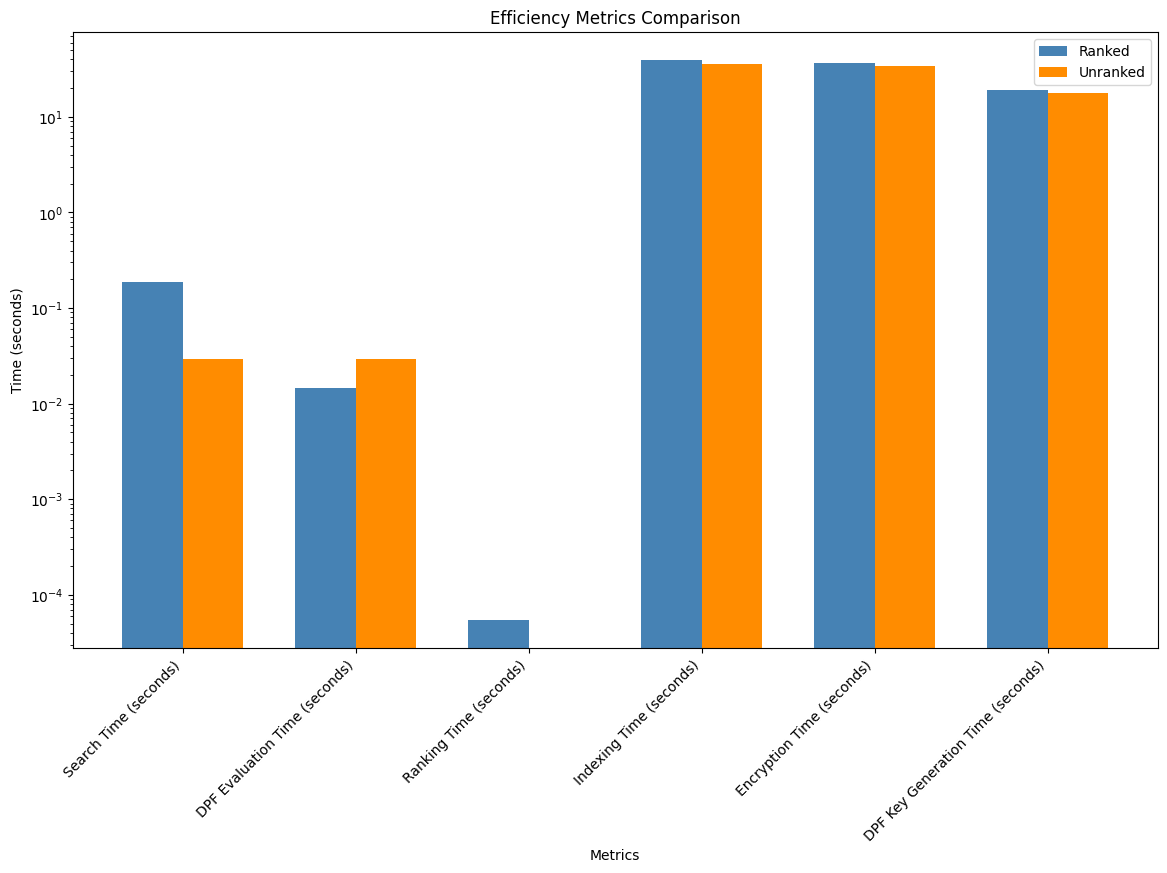

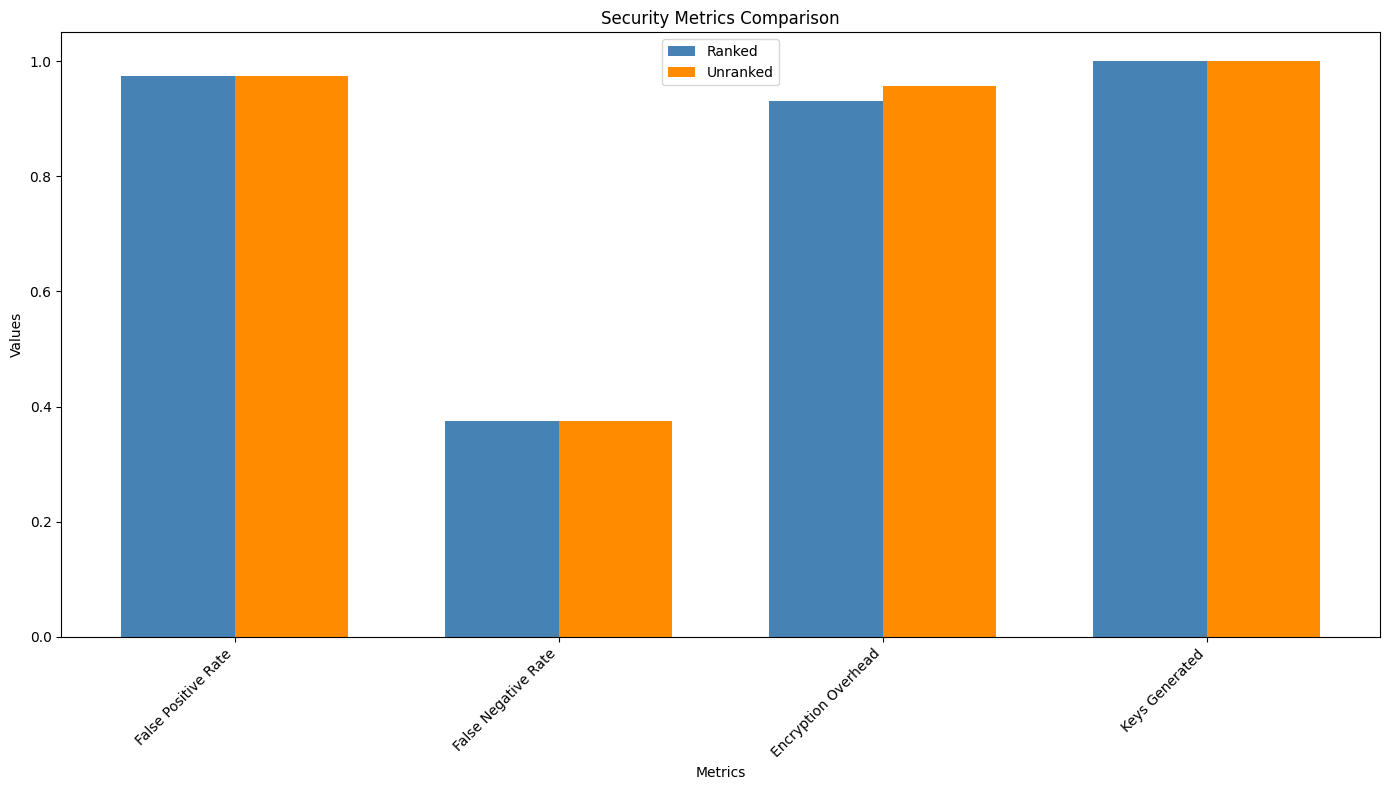

In [11]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load ranked search metrics
with open('ranked_search_metrics.json', 'r') as f:
    ranked_metrics = json.load(f)

# Load unranked search metrics
with open('unranked_search_metrics.json', 'r') as f:
    unranked_metrics = json.load(f)

# Extract efficiency metrics for comparison
efficiency_data = {
    'Metric': [
        'Search Time (seconds)',
        'DPF Evaluation Time (seconds)',
        'Ranking Time (seconds)',
        'Indexing Time (seconds)',
        'Encryption Time (seconds)',
        'DPF Key Generation Time (seconds)'
    ],
    'Ranked Search': [
        ranked_metrics['search_metrics'].get('search_time', 0),
        ranked_metrics['search_metrics'].get('dpf_evaluation_time', 0),
        ranked_metrics['search_metrics'].get('ranking_time', 0),
        ranked_metrics['index_metrics'].get('indexing_time', 0),
        ranked_metrics['index_metrics'].get('encryption_time', 0),
        ranked_metrics['index_metrics'].get('dpf_key_generation_time', 0)
    ],
    'Unranked Search': [
        unranked_metrics['search_metrics'].get('search_time', 0),
        unranked_metrics['search_metrics'].get('dpf_evaluation_time', 0),
        0,  # No ranking time for unranked search
        unranked_metrics['index_metrics'].get('indexing_time', 0),
        unranked_metrics['index_metrics'].get('encryption_time', 0),
        unranked_metrics['index_metrics'].get('dpf_key_generation_time', 0)
    ]
}

# Extract security metrics for comparison
security_data = {
    'Metric': [
        'False Positive Rate',
        'False Negative Rate',
        'Encryption Overhead',
        'Keys Generated'
    ],
    'Ranked Search': [
        ranked_metrics['security_metrics'].get('false_positive_rate', 0),
        ranked_metrics['security_metrics'].get('false_negative_rate', 0),
        ranked_metrics['security_metrics'].get('encryption_overhead', 0),
        ranked_metrics['security_metrics'].get('keys_generated', 0)
    ],
    'Unranked Search': [
        unranked_metrics['security_metrics'].get('false_positive_rate', 0),
        unranked_metrics['security_metrics'].get('false_negative_rate', 0),
        unranked_metrics['security_metrics'].get('encryption_overhead', 0),
        unranked_metrics['security_metrics'].get('keys_generated', 0)
    ]
}

# Create DataFrames for tabular display
df_efficiency = pd.DataFrame(efficiency_data)
df_security = pd.DataFrame(security_data)

print("Comparison of Ranked and Unranked Search Efficiency Metrics")
print(df_efficiency)
print("\nComparison of Ranked and Unranked Search Security Metrics")
print(df_security)

# Plotting the efficiency comparison
fig_eff, ax_eff = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index_eff = range(len(efficiency_data['Metric']))

bar1 = ax_eff.bar(index_eff, df_efficiency['Ranked Search'], bar_width, label='Ranked', color='steelblue')
bar2 = ax_eff.bar([i + bar_width for i in index_eff], df_efficiency['Unranked Search'], bar_width, label='Unranked', color='darkorange')

ax_eff.set_xlabel('Metrics')
ax_eff.set_ylabel('Time (seconds)')
ax_eff.set_yscale('log')  # Set y-axis to logarithmic scale
ax_eff.set_title('Efficiency Metrics Comparison')
ax_eff.set_xticks([i + bar_width / 2 for i in index_eff])
ax_eff.set_xticklabels(efficiency_data['Metric'], rotation=45, ha='right')
ax_eff.legend()

# Plotting the security comparison
fig_sec, ax_sec = plt.subplots(figsize=(14, 8))

index_sec = range(len(security_data['Metric']))

bar1 = ax_sec.bar(index_sec, df_security['Ranked Search'], bar_width, label='Ranked', color='steelblue')
bar2 = ax_sec.bar([i + bar_width for i in index_sec], df_security['Unranked Search'], bar_width, label='Unranked', color='darkorange')

ax_sec.set_xlabel('Metrics')
ax_sec.set_ylabel('Values')
ax_sec.set_title('Security Metrics Comparison')
ax_sec.set_xticks([i + bar_width / 2 for i in index_sec])
ax_sec.set_xticklabels(security_data['Metric'], rotation=45, ha='right')
ax_sec.legend()

plt.tight_layout()
plt.show()




Comparison of Ranked and Unranked Search Efficiency Metrics
                              Metric  Ranked Search  Unranked Search
0              Search Time (seconds)       0.009266         0.000789
1      DPF Evaluation Time (seconds)       0.000646         0.000750
2             Ranking Time (seconds)       0.000016         0.000000
3            Indexing Time (seconds)      40.937437        38.484231
4          Encryption Time (seconds)      37.884078        36.841655
5  DPF Key Generation Time (seconds)      19.861279        19.036669

Comparison of Ranked and Unranked Search Security Metrics
                Metric  Ranked Search  Unranked Search
0  False Positive Rate       0.363636         0.363636
1  False Negative Rate       0.125000         0.125000
2  Encryption Overhead       0.925414         0.957318
3       Keys Generated       1.000000         1.000000


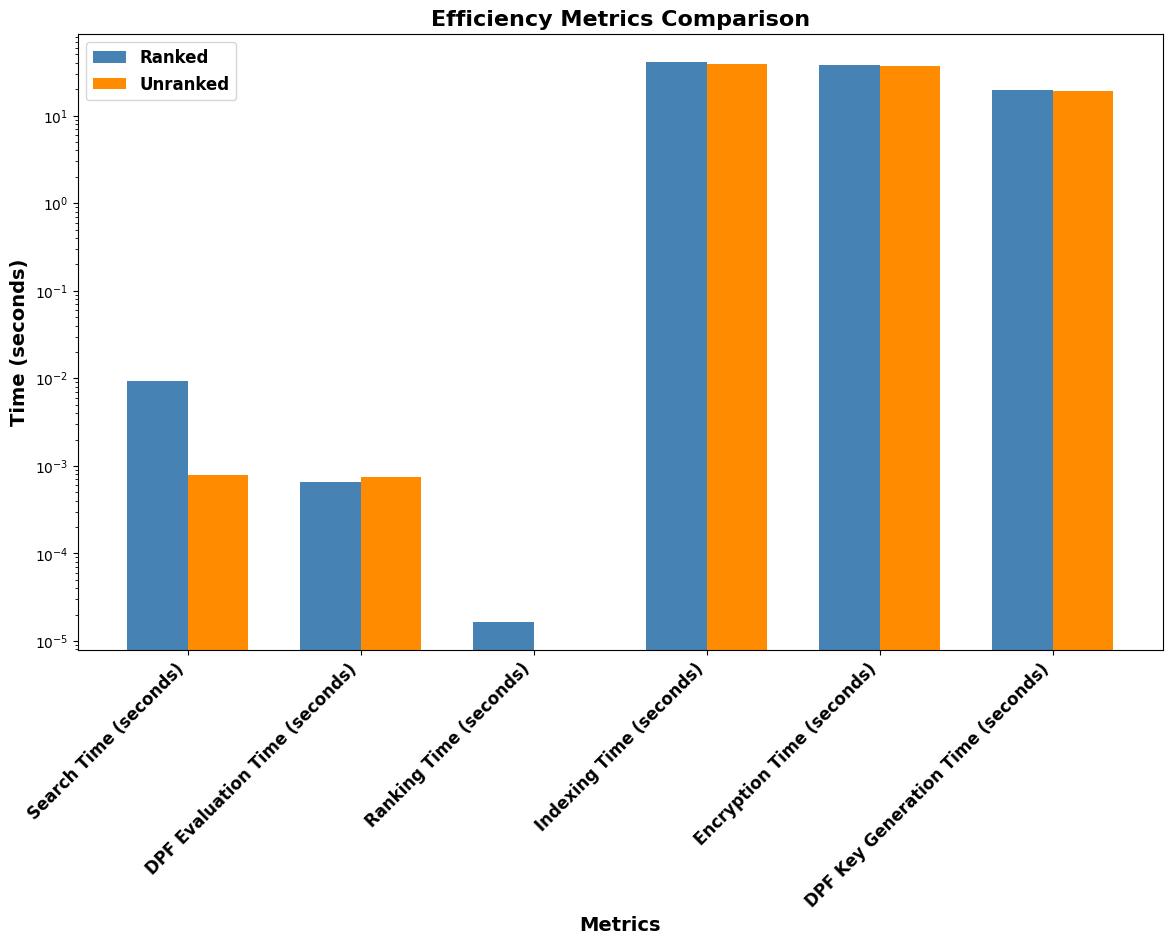

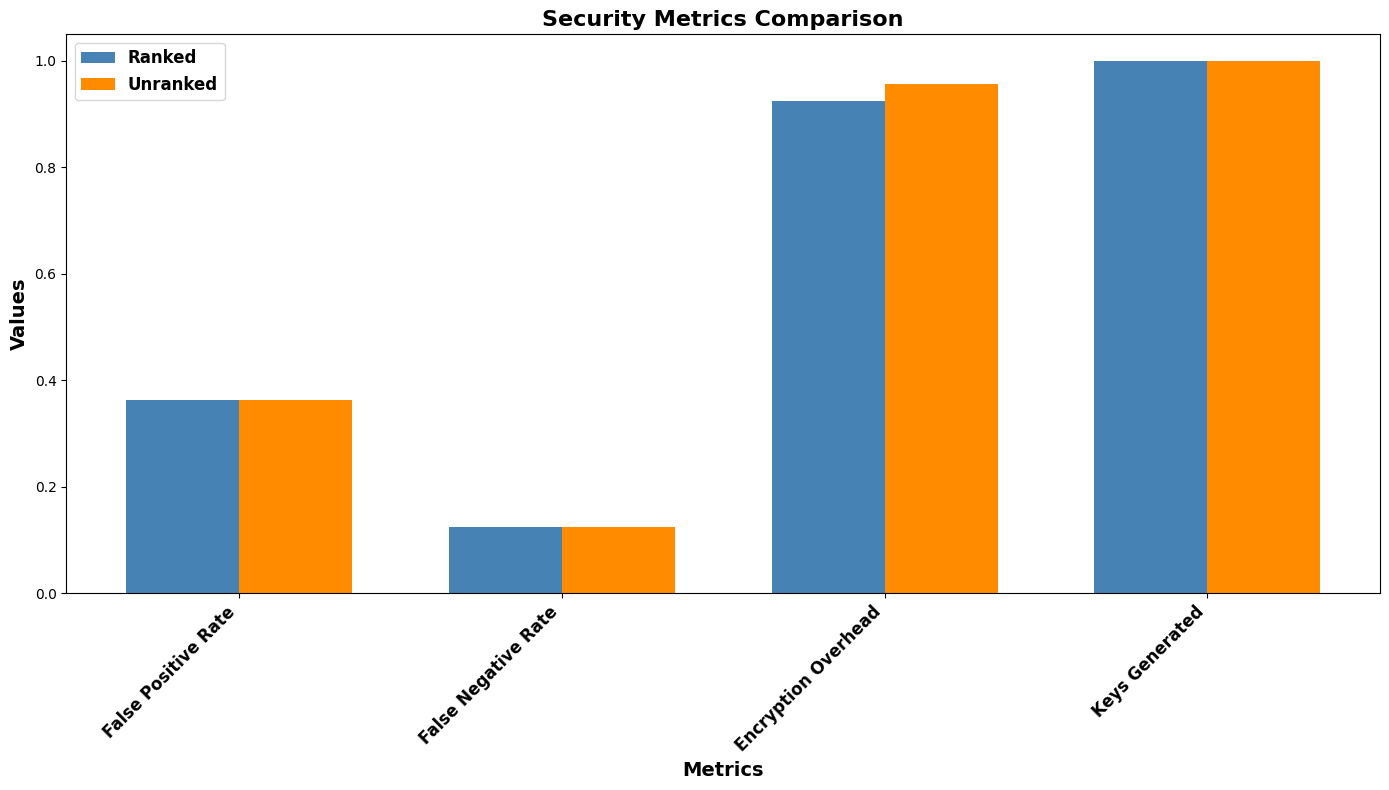

In [72]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load ranked search metrics
with open('ranked_search_metrics.json', 'r') as f:
    ranked_metrics = json.load(f)

# Load unranked search metrics
with open('unranked_search_metrics.json', 'r') as f:
    unranked_metrics = json.load(f)

# Extract efficiency metrics for comparison
efficiency_data = {
    'Metric': [
        'Search Time (seconds)',
        'DPF Evaluation Time (seconds)',
        'Ranking Time (seconds)',
        'Indexing Time (seconds)',
        'Encryption Time (seconds)',
        'DPF Key Generation Time (seconds)'
    ],
    'Ranked Search': [
        ranked_metrics['search_metrics'].get('search_time', 0),
        ranked_metrics['search_metrics'].get('dpf_evaluation_time', 0),
        ranked_metrics['search_metrics'].get('ranking_time', 0),
        ranked_metrics['index_metrics'].get('indexing_time', 0),
        ranked_metrics['index_metrics'].get('encryption_time', 0),
        ranked_metrics['index_metrics'].get('dpf_key_generation_time', 0)
    ],
    'Unranked Search': [
        unranked_metrics['search_metrics'].get('search_time', 0),
        unranked_metrics['search_metrics'].get('dpf_evaluation_time', 0),
        0,  # No ranking time for unranked search
        unranked_metrics['index_metrics'].get('indexing_time', 0),
        unranked_metrics['index_metrics'].get('encryption_time', 0),
        unranked_metrics['index_metrics'].get('dpf_key_generation_time', 0)
    ]
}

# Extract security metrics for comparison
security_data = {
    'Metric': [
        'False Positive Rate',
        'False Negative Rate',
        'Encryption Overhead',
        'Keys Generated'
    ],
    'Ranked Search': [
        ranked_metrics['security_metrics'].get('false_positive_rate', 0),
        ranked_metrics['security_metrics'].get('false_negative_rate', 0),
        ranked_metrics['security_metrics'].get('encryption_overhead', 0),
        ranked_metrics['security_metrics'].get('keys_generated', 0)
    ],
    'Unranked Search': [
        unranked_metrics['security_metrics'].get('false_positive_rate', 0),
        unranked_metrics['security_metrics'].get('false_negative_rate', 0),
        unranked_metrics['security_metrics'].get('encryption_overhead', 0),
        unranked_metrics['security_metrics'].get('keys_generated', 0)
    ]
}

# Create DataFrames for tabular display
df_efficiency = pd.DataFrame(efficiency_data)
df_security = pd.DataFrame(security_data)

print("Comparison of Ranked and Unranked Search Efficiency Metrics")
print(df_efficiency)
print("\nComparison of Ranked and Unranked Search Security Metrics")
print(df_security)

# Plotting the efficiency comparison
fig_eff, ax_eff = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index_eff = range(len(efficiency_data['Metric']))

bar1 = ax_eff.bar(index_eff, df_efficiency['Ranked Search'], bar_width, label='Ranked', color='steelblue')
bar2 = ax_eff.bar([i + bar_width for i in index_eff], df_efficiency['Unranked Search'], bar_width, label='Unranked', color='darkorange')

ax_eff.set_xlabel('Metrics', fontsize=14, fontweight='bold')  # Bold and increase font size
ax_eff.set_ylabel('Time (seconds)', fontsize=14, fontweight='bold')  # Bold and increase font size
ax_eff.set_yscale('log')  # Set y-axis to logarithmic scale
ax_eff.set_title('Efficiency Metrics Comparison', fontsize=16, fontweight='bold')  # Bold and increase font size
ax_eff.set_xticks([i + bar_width / 2 for i in index_eff])
ax_eff.set_xticklabels(efficiency_data['Metric'], rotation=45, ha='right', fontsize=12, fontweight='bold')  # Bold and increase font size

legend = ax_eff.legend(fontsize=12)  # Increase font size
plt.setp(legend.get_texts(), fontweight='bold')  # Make legend text bold

# Plotting the security comparison
fig_sec, ax_sec = plt.subplots(figsize=(14, 8))

index_sec = range(len(security_data['Metric']))

bar1 = ax_sec.bar(index_sec, df_security['Ranked Search'], bar_width, label='Ranked', color='steelblue')
bar2 = ax_sec.bar([i + bar_width for i in index_sec], df_security['Unranked Search'], bar_width, label='Unranked', color='darkorange')

ax_sec.set_xlabel('Metrics', fontsize=14, fontweight='bold')  # Bold and increase font size
ax_sec.set_ylabel('Values', fontsize=14, fontweight='bold')  # Bold and increase font size
ax_sec.set_title('Security Metrics Comparison', fontsize=16, fontweight='bold')  # Bold and increase font size
ax_sec.set_xticks([i + bar_width / 2 for i in index_sec])
ax_sec.set_xticklabels(security_data['Metric'], rotation=45, ha='right', fontsize=12, fontweight='bold')  # Bold and increase font size

legend = ax_sec.legend(fontsize=12)  # Increase font size
plt.setp(legend.get_texts(), fontweight='bold')  # Make legend text bold

plt.tight_layout()
plt.show()
